# Ejercicio en clase: Modelos de Ensamble

Este ejercicio tiene como objetivos:

* Aprender a entrenar modelos de ensamble por Stacking, Random Forests y AdaBoost
* Consolidar el conocimiento del proceso de aprendizaje y evaluación de modelos predictivos
* Visualizar overfitting usando curvas de aprendizaje

# Ensamble por votación manual

## Ejemplo de `scikit-learn`

Como inicio de este ejercicio tomemos una ilustración de la documentación de `scikit-learn`: [Plot the decision boundaries of a VotingClassifier](http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html). En ella se diagrama las fronteras de decisión de un modelo de ensamble por votación, usando dos de las cuatro características del [Iris Flower Data Set](https://en.wikipedia.org/wiki/Iris_flower_data_set): largo del sépalo y largo del pétalo.

El conjunto de datos Iris contiene 50 muestras de cada una de tres posibles especies de Iris: *Iris setosa, Iris virginica* e *Iris versicolor*. Para cada muestra se tiene la medida en centímetros de cuatro características: largo y ancho de los pétalos y de los sépalos.

Este modelo por ensamble combina por votación las probabilidades de clase asignadas por tres clasificadores de base: un árbol de decisión (`DecisionTreeClassifier`), un modelo k-NN (`KNeighborsClassifier`), y una máquina de soporte vectorial con kernel gaussiano (`SVC`).

Se ha asignado manualmente a los modelos los pesos `[2, 1, 2]`, lo que significa que, al promediar las probabilidades obtenidas de los modelos, las probabilidades del árbol de decisión y de la máquina de soporte vectorial cuentan el doble que las del modelo k-NN.

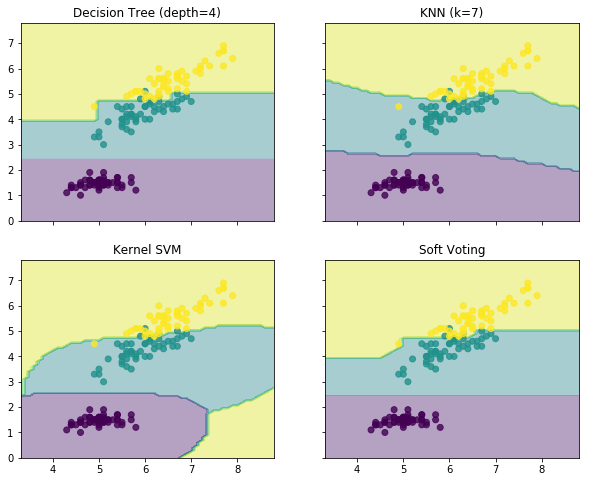

In [1]:
# Tomado de http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_decision_regions.html

from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Loading some example data
iris = datasets.load_iris()
X = iris.data[:, [0, 2]]
y = iris.target

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

## Evaluación del modelo de ensamble por votación manual

Observemos la exactitud *(accuracy)* de cada uno los modelos:

In [2]:
print ("Exactitud del modelo de árbol de decisión     :", clf1.score(X, y))
print ("Exactitud del modelo de k-NN                  :", clf2.score(X, y))
print ("Exactitud del modelo SVM de kernel gaussiano  :", clf3.score(X, y))
print ("Exactitud del modelo de ensamble por votación :", eclf.score(X, y))


Exactitud del modelo de árbol de decisión     : 0.98
Exactitud del modelo de k-NN                  : 0.966666666667
Exactitud del modelo SVM de kernel gaussiano  : 0.96
Exactitud del modelo de ensamble por votación : 0.98


**Pregunta 1:** Dado que los modelos anteriores han sido entrenados en la totalidad de instancias del conjunto de datos Iris, ¿se puede decir que los valores anteriores son buenos indicadores del rendimiento esperado fuera de la muestra?

## Ensamble por Apilamiento *(Stacking)* con Regresión logística

En el ejemplo anterior, se asignó manualmente los pesos `[2, 1, 2]` a los modelos de base. Tratemos ahora de emplear las predicciones probabilísticas de los modelos de base para entrenar nuestro modelo de ensamble. Como algoritmo de aprendizaje usaremos la regresión logística.

Para tener una mejor evaluación, vamos a reservar 30% de los datos como conjunto de pruebas.

Asimismo, dado que el conjunto de datos es pequeño, usaremos validación cruzada para el entrenamiento del modelo de ensamble.

In [3]:
from sklearn.model_selection import train_test_split

# Partición del conjunto de datos
# El parámetro stratify nos permite asegurar que en la partición se conserve la proporción de muestras con la clase indicada
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

**Pregunta 2:** ¿Cuántas instancias tiene el conjunto de prueba?

In [4]:
print('Número de instancias del conjunto de prueba :', len(y_test))  ## COMPLETAR...

Número de instancias del conjunto de prueba : 45


A continuación entrenaremos los modelos y juntaremos en un `DataFrame` de `pandas` las predicciones de los modelos de base para el conjunto de entrenamiento:

In [5]:
modelo1 = DecisionTreeClassifier(max_depth=4)
modelo2 = KNeighborsClassifier(n_neighbors=7)
modelo3 = SVC(kernel='rbf', probability=True)

modelo1.fit(X_train, y_train)
modelo2.fit(X_train, y_train)
modelo3.fit(X_train, y_train)

predicciones_base_train = pd.concat([pd.DataFrame(modelo1.predict_proba(X_train)),
                             pd.DataFrame(modelo2.predict_proba(X_train)),
                             pd.DataFrame(modelo3.predict_proba(X_train))], 
                         axis=1)
predicciones_base_train.columns = ['dt-setosa', 'dt-virginica', 'dt-versicolor',
                            'knn-setosa', 'knn-virginica', 'knn-versicolor',
                            'svc-setosa', 'svc-virginica', 'svc-versicolor']

# Mostremos las predicciones de cada modelo para las primeras 10 instancias del conjunto de entrenamiento
predicciones_base_train.head(10)

,dt-setosa,dt-virginica,dt-versicolor,knn-setosa,knn-virginica,knn-versicolor,svc-setosa,svc-virginica,svc-versicolor
0,0.0,0.166667,0.833333,0.0,0.285714,0.714286,0.012785,0.160451,0.826763
1,0.0,0.000000,1.000000,0.0,0.000000,1.000000,0.020739,0.056195,0.923066
2,0.0,0.166667,0.833333,0.0,0.142857,0.857143,0.013002,0.217171,0.769827
3,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.010532,0.963736,0.025732
4,0.0,0.000000,1.000000,0.0,0.142857,0.857143,0.015503,0.005891,0.978606
5,0.0,0.000000,1.000000,0.0,0.000000,1.000000,0.015889,0.023761,0.960350
6,0.0,1.000000,0.000000,0.0,1.000000,0.000000,0.014126,0.964673,0.021201
7,1.0,0.000000,0.000000,1.0,0.000000,0.000000,0.966023,0.016002,0.017976
8,0.0,0.166667,0.833333,0.0,0.571429,0.428571,0.013211,0.488744,0.498046
9,0.0,0.166667,0.833333,0.0,0.285714,0.714286,0.013701,0.243811,0.742488


**Pregunta 3:** En las predicciones de las 10 primeras instancias del conjunto de entrenamiento, ¿hay algún caso en el que dos o más clasificadores estén en desacuerdo sobre la clase más probable a asignar?

**Rpta.:** Sí, en la novena instancia. DT predice versicolor. k-NN y SVC predicen virginica.

**Pregunta 4:** ¿Cuál es la clase real de la novena instancia del conjunto de entrenamiento? (0 = setosa; 1 = virginica; 2 = versicolor)

In [6]:
y_train[8]

1

Usemos las predicciones de los modelos de base para entrenar nuestro modelo de ensamble. Emplearemos *grid search* con validación cruzada estratificada *10-fold* para determinar el mejor valor del parámetro de complejidad $C = 1/\lambda$ de nuestro modelo de regresión logística.

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

mejor_score = 0
mejor_C = None

for C in np.logspace(-2,4,13):  # ~ [0.01, 0.03, 0.1, ..., 10000] 
    ensamble = LogisticRegression(penalty='l2', C=C, random_state=0)
    scores_val = cross_val_score(ensamble, predicciones_base_train, y_train, cv=10)
    score_val_medio = np.mean(scores_val)  # Obtener la exactitud media de la validación cruzada en cada fold
    if score_val_medio > mejor_score: 
        mejor_score = score_val_medio
        mejor_C = C

# Habiendo obtenido el mejor C, ajustar el modelo con todo el conjunto de entrenamiento
ensamble = LogisticRegression(penalty='l2', C=mejor_C, random_state=0)
ensamble.fit(predicciones_base_train, y_train)

print ("Rendimiento en el conjunto de entrenamiento")
print ("-------------------------------------------")
print ("Exactitud del modelo de árbol de decisión                :", modelo1.score(X_train, y_train))
print ("Exactitud del modelo de k-NN                             :", modelo2.score(X_train, y_train))
print ("Exactitud del modelo SVM de kernel gaussiano             :", modelo3.score(X_train, y_train))
print ("Exactitud del modelo de ensamble por regresión logística :", ensamble.score(predicciones_base_train, y_train))



Rendimiento en el conjunto de entrenamiento
-------------------------------------------
Exactitud del modelo de árbol de decisión                : 0.980952380952
Exactitud del modelo de k-NN                             : 0.961904761905
Exactitud del modelo SVM de kernel gaussiano             : 0.952380952381
Exactitud del modelo de ensamble por regresión logística : 0.980952380952


Calculemos el rendimiento en el conjunto de prueba:

In [8]:
predicciones_base_test = pd.concat([pd.DataFrame(modelo1.predict_proba(X_test)),
                             pd.DataFrame(modelo2.predict_proba(X_test)),
                             pd.DataFrame(modelo3.predict_proba(X_test))], 
                         axis=1)

print ("Rendimiento en el conjunto de prueba")
print ("------------------------------------")
print ("Exactitud del modelo de árbol de decisión                :", modelo1.score(X_test, y_test))  ## COMPLETAR...
print ("Exactitud del modelo de k-NN                             :", modelo2.score(X_test, y_test))  ## COMPLETAR...
print ("Exactitud del modelo SVM de kernel gaussiano             :", modelo3.score(X_test, y_test))  ## COMPLETAR...
print ("Exactitud del modelo de ensamble por regresión logística :", ensamble.score(predicciones_base_test, y_test))  ## COMPLETAR...



Rendimiento en el conjunto de prueba
------------------------------------
Exactitud del modelo de árbol de decisión                : 0.977777777778
Exactitud del modelo de k-NN                             : 0.955555555556
Exactitud del modelo SVM de kernel gaussiano             : 0.955555555556
Exactitud del modelo de ensamble por regresión logística : 0.977777777778


**Pregunta 5:** ¿Cuántas instancias fueron mal clasificadas por el modelo de ensamble en el conjunto de pruebas?

In [9]:
len(X_test) * (1 - ensamble.score(predicciones_base_test, y_test))

1.0000000000000013

# Ensamble por Bagging con Random Forests

En esta parte del ejercicio usaremos el conjunto de datos [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic). A partir de un conjunto de características sobre cada pasajero se requiere predecir si sobrevivió o no a la tragedia. Ver la [descripción de los datos](https://www.kaggle.com/c/titanic/data)

En los siguientes pasos tenemos un ejemplo básico del proceso típico de aprendizaje de modelos predictivos.

## Obtención y carga de datos

In [10]:
titanic_train = pd.read_csv('titanic/train.csv')
titanic_test = pd.read_csv('titanic/test.csv')
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Preparación de los datos

`Pandas` nos permite seleccionar una columna como índice. En nuestro caso el índice es conveniente hacer con la columna `PassengerId`.

In [12]:
titanic_train.set_index('PassengerId', inplace=True)
titanic_test.set_index('PassengerId', inplace=True)
titanic_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Lidiando con los valores faltantes

Usando un simple conteo en el conjunto de entrenamiento, podemos verificar que falta algunos valores para `Embarked`, `Age` y sobre todo `Cabin`.

In [13]:
titanic_train.count()

Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64

En el conjunto de prueba, vemos que falta también un dato en `Fare`:

In [14]:
titanic_test.count()

Pclass      418
Name        418
Sex         418
Age         332
SibSp       418
Parch       418
Ticket      418
Fare        417
Cabin        91
Embarked    418
dtype: int64

Hay diversas maneras de lidiar con valores faltantes. En este ejercicio haremos las siguientes opciones:

* `Embarked`: Sólo falta dos valores en el conjunto de entrenamiento. Imputaremos la moda (valor más frecuente). 

In [15]:
# Sólo hay dos valores faltantes NaN. La moda (valor más frecuente) es 'S'
titanic_train['Embarked'].value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [16]:
# Registramos el índice (PassengerId) de los dos casos, y luego mostramos ambos registros
embarked_NaN = titanic_train[titanic_train['Embarked'].isnull()].index
titanic_train.loc[embarked_NaN]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [17]:
# Calculamos la moda
embarked_moda = titanic_train['Embarked'].mode()[0]

In [18]:
# Imputamos la moda en los valores faltantes
titanic_train.loc[embarked_NaN,'Embarked'] = embarked_moda
titanic_train.loc[embarked_NaN]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


* `Age`: Incluiremos un campo booleano de `EdadDesconocida` y adicionalmente completaremos el valor con la mediana.

In [19]:
# Creamos una columna para caracterizar los casos con edad desconocida
titanic_train['EdadDesconocida'] = titanic_train['Age'].isnull()
titanic_test['EdadDesconocida'] = titanic_test['Age'].isnull()

# Calculamos la mediana de Age y la imputamos en los valores faltantes de ambos conjuntos
# Mostramos cómo hacerlo con DataFrame.fillna()
age_mediana = titanic_train['Age'].median()
titanic_train['Age'].fillna(age_mediana, inplace=True)
titanic_test['Age'].fillna(age_mediana, inplace=True)

* `Fare`: Un solo caso, en el conjunto de prueba. Imputaremos la mediana del conjunto de entrenamiento.

In [20]:
fare_mediana = titanic_train['Fare'].median()
titanic_test['Fare'].fillna(fare_mediana, inplace=True)

* `Cabin`: No usaremos la clase `Cabin`, severamente incompleta.

In [21]:
titanic_train.drop(['Cabin'], axis=1, inplace=True)
titanic_test.drop(['Cabin'], axis=1, inplace=True)

### Selección de características

Ya hemos retirado la columna `Cabin`, severamente incompleta. Retiraremos también `Name` y `Ticket`.

In [22]:
titanic_train.drop(['Name','Ticket'], axis=1, inplace=True)
titanic_test.drop(['Name','Ticket'], axis=1, inplace=True)

Podemos añadir otras meta-características. Por ejemplo, podríamos crear una columna `ViajaSolo` cuando no el pasajero no viajó  con ningún familiar (`SibSp` y `Parch` con valor 0).

In [23]:
titanic_train['ViajaSolo'] = ((titanic_train['SibSp'] + titanic_train['Parch']) == 0)
titanic_test['ViajaSolo'] = ((titanic_test['SibSp'] + titanic_test['Parch']) == 0)
titanic_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,False,False
2,1,1,female,38.0,1,0,71.2833,C,False,False
3,1,3,female,26.0,0,0,7.9250,S,False,True
4,1,1,female,35.0,1,0,53.1000,S,False,False
5,0,3,male,35.0,0,0,8.0500,S,False,True


In [24]:
titanic_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,EdadDesconocida,ViajaSolo
PassengerId,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,False,True
893,3,female,47.0,1,0,7.0000,S,False,False
894,2,male,62.0,0,0,9.6875,Q,False,True
895,3,male,27.0,0,0,8.6625,S,False,True
896,3,female,22.0,1,1,12.2875,S,False,False


Añade las columnas `MenorDeEdad` y `AdultoMayor`. Considera como menor de edad a todos aquellos menores de 18.0 años. Considera Adulto Mayor a los mayores de 55.0 años. Hazlo tanto en el conjunto de entrenamiento como en el de pruebas.

In [25]:
## COMPLETAR
titanic_train['MenorDeEdad'] = (titanic_train['Age'] < 18.0)
titanic_test['MenorDeEdad'] = (titanic_test['Age'] < 18.0)

titanic_train['AdultoMayor'] = (titanic_train['Age'] > 55.0)
titanic_test['AdultoMayor'] = (titanic_test['Age'] > 55.0)

titanic_train['MenorDeEdad'].value_counts()

False    778
True     113
Name: MenorDeEdad, dtype: int64

**Pregunta 6:** ¿Cuántos menores de edad hay en el conjunto de entrenamiento?

In [26]:
titanic_test['AdultoMayor'].value_counts()

False    399
True      19
Name: AdultoMayor, dtype: int64

**Pregunta 7:** ¿Cuántos adultos mayores hay en el conjunto de pruebas?

### Codificación de variables categóricas

Tenemos también tres variables categóricas (`Sex`, `Pclass` y `Embarked`).

* `Sex`: la podemos reemplazar por un valor binario `EsMujer`. 

In [27]:
titanic_train['EsMujer'] = (titanic_train['Sex'] == 'female')
titanic_test['EsMujer'] = (titanic_test['Sex'] == 'female')

titanic_train.drop(['Sex'], axis=1, inplace=True)
titanic_test.drop(['Sex'], axis=1, inplace=True)

* `Pclass` y `Embarked`: Usaremos *one-hot encoding* con la función `DataFrame.get_dummies` de `pandas`. Observa que `Pclass` es categórica no obstante esté siendo representada con una codificación numérica.

In [28]:
cols_categoricas = ['Pclass','Embarked']

titanic_train = pd.get_dummies(titanic_train, columns=cols_categoricas)
titanic_test = pd.get_dummies(titanic_test, columns=cols_categoricas)

titanic_train.head()

,Survived,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,False,False,False,False,False,0,0,1,0,0,1
2,1,38.0,1,0,71.2833,False,False,False,False,True,1,0,0,1,0,0
3,1,26.0,0,0,7.9250,False,True,False,False,True,0,0,1,0,0,1
4,1,35.0,1,0,53.1000,False,False,False,False,True,1,0,0,0,0,1
5,0,35.0,0,0,8.0500,False,True,False,False,False,0,0,1,0,0,1


In [29]:
titanic_test.head()

,Age,SibSp,Parch,Fare,EdadDesconocida,ViajaSolo,MenorDeEdad,AdultoMayor,EsMujer,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
892,34.5,0,0,7.8292,False,True,False,False,False,0,0,1,0,1,0
893,47.0,1,0,7.0000,False,False,False,False,True,0,0,1,0,0,1
894,62.0,0,0,9.6875,False,True,False,True,False,0,1,0,0,1,0
895,27.0,0,0,8.6625,False,True,False,False,False,0,0,1,0,0,1
896,22.0,1,1,12.2875,False,False,False,False,True,0,0,1,0,0,1


### Lidiar con datos desbalanceados

Tenemos un caso de datos desbalanceados. El número de muertos es claramente mayor que el de sobrevivientes:

In [30]:
titanic_train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

Hay diversas técnicas para lidiar con datos desbalanceados. Se puede leer más sobre eso en el artículo [He, H., & Garcia, E. A. (2009). Learning from imbalanced data. IEEE Transactions on Knowledge and Data Engineering, 21(9), 1263–1284. https://doi.org/10.1109/TKDE.2008.239](http://www.ele.uri.edu/faculty/he/PDFfiles/ImbalancedLearning.pdf)

En este ejercicio usaremos una aproximación llamada *random oversampling*, que consiste en duplicar ejemplos de la clase minoritaria hasta equilibrar el número de ejemplos por clase.

In [31]:
num_no_sobrevivientes = titanic_train['Survived'].value_counts()[0]
num_sobrevivientes = titanic_train['Survived'].value_counts()[1]

num_muestras = num_no_sobrevivientes - num_sobrevivientes
sobrevivientes = titanic_train[titanic_train['Survived'] == 1]
muestra_sobrevivientes = sobrevivientes.sample(n=num_muestras, random_state=0)

titanic_train_sample = titanic_train.append(muestra_sobrevivientes)

# Verificamos la distribución de la clase
titanic_train_sample['Survived'].value_counts()

1    549
0    549
Name: Survived, dtype: int64

## Separación de conjunto de validación

Antes de reservar un conjunto de validación, separemos la clase a predecir (`Survived`) del resto de variables.

In [32]:
X_train_val = titanic_train_sample.drop('Survived', axis=1)
y_train_val = titanic_train_sample['Survived']

Procedemos a separar un conjunto de validación.

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)


## Entrenamiento de Random Forests

El clasificador de Random Forest tiene diversos parámetros que pueden ser optimizados. Se puede ver la documentación de [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Nos limitaremos a identificar el número óptimo de modelos base *(estimators)* y revisar el comportamiento de la curva de aprendizaje y otras medidas de evaluación.

In [34]:
from sklearn.ensemble import RandomForestClassifier

mejor_score = 0
mejor_n_estimators = None
mejor_modelo_rf = None
rf_error_train = []
rf_error_val = []

n_estimators_grid = np.linspace(2,80,40).astype(int)  # ~ [2, 4, 6, ..., 80] 

for n_estimators in n_estimators_grid: 
    modelo_rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
    modelo_rf.fit(X_train, y_train)
    
    score_train = modelo_rf.score(X_train, y_train)
    rf_error_train.append(1 - score_train)
    
    score_val = modelo_rf.score(X_val, y_val)
    rf_error_val.append(1 - score_val)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_n_estimators = n_estimators
        mejor_modelo_rf = modelo_rf

modelo_rf = mejor_modelo_rf
modelo_rf.fit(X_train, y_train)

print ("Mejor valor de n_estimators :", mejor_n_estimators)
print ("Exactitud de RandomForest en conjunto de entrenamiento :", modelo_rf.score(X_train, y_train))
print ("Exactitud de RandomForest en conjunto de validación    :", modelo_rf.score(X_val, y_val))

Mejor valor de n_estimators : 6
Exactitud de RandomForest en conjunto de entrenamiento : 0.969248291572
Exactitud de RandomForest en conjunto de validación    : 0.845454545455


### Curva de aprendizaje por número de modelos base

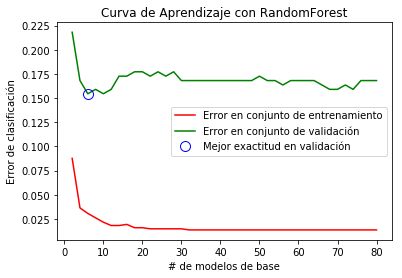

In [35]:
plt.figure()
plt.plot(n_estimators_grid, rf_error_train,
        label='Error en conjunto de entrenamiento',
        color='red')
plt.plot(n_estimators_grid, rf_error_val,
        label='Error en conjunto de validación',
        color='green')
plt.plot(mejor_n_estimators, 1-mejor_score, 'o', markersize=10,
         label="Mejor exactitud en validación", fillstyle="none", c='b', mew=1)
plt.xlabel("# de modelos de base")
plt.ylabel("Error de clasificación")
plt.title("Curva de Aprendizaje con RandomForest")
plt.legend(loc=0, numpoints=1)
plt.show()

Recuerda que el sobreajuste se da cuando las mejoras en los resultados del conjunto de entrenamiento no se corresponden con mejoras fuera del conjunto de entrenamiento.

**Pregunta 8** ¿Cuál de las siguientes afirmaciones representa mejor la curva visualizada?

* El modelo tiene severo overfitting de inicio a fin.
* El modelo muestra overfitting moderado desde que el número de modelos de base es mayor a 6, pero luego mantiene un rendimiento estable en el conjunto de validación.
* El modelo no presenta overfitting.
* Las curvas de aprendizaje de entrenamiento y validación son paralelas.

### Curva ROC

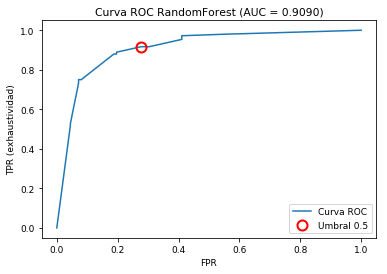

In [36]:
from sklearn import metrics

y_pred_val = modelo_rf.predict_proba(X_val)[:,1]
fpr, tpr, umbrales = metrics.roc_curve(y_val, y_pred_val)
auc_roc = metrics.roc_auc_score(y_val, y_pred_val)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC RandomForest (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc=4, numpoints=1)

# Ensamble con AdaBoost

AdaBoost trabaja mejor con modelos base de aprendizaje débil *(weak learners)*. Por defecto utiliza árboles de decisión de profundidad 1 *(decision stumps)*. Tiene también diversos parámetros que pueden ser optimizados. Se puede ver la documentación de [sklearn.ensemble.AdaBoostClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Los principales parámetros a optimizar son el número de modelos de base (`n_estimators`) y los parámetros propios del modelo de base.

Nos limitaremos a identificar el valor óptimo de `min_samples_leaf` del modelo base elegido (`DecisionTreeClassifier`)

In [37]:
from sklearn.ensemble import AdaBoostClassifier

n_estimators=200
min_samples_leaf_grid = np.linspace(1,10,10).astype(int) 

In [38]:
mejor_score = 0
mejor_min_samples_leaf = None

for min_samples_leaf in min_samples_leaf_grid: 
    base_estimator = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, random_state=0)
    modelo_ab = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, random_state=0)
    modelo_ab.fit(X_train, y_train)
    
    score_val = modelo_ab.score(X_val, y_val)
    
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_min_samples_leaf = min_samples_leaf
        mejor_modelo_ab = modelo_ab

modelo_ab = mejor_modelo_ab
modelo_ab.fit(X_train, y_train)

print ("Mejor valor de min_samples_leaf :", mejor_min_samples_leaf)
print ("Exactitud de AdaBoost en conjunto de entrenamiento :", modelo_ab.score(X_train, y_train))
print ("Exactitud de AdaBoost en conjunto de validación    :", mejor_score)

Mejor valor de min_samples_leaf : 2
Exactitud de AdaBoost en conjunto de entrenamiento : 0.986332574032
Exactitud de AdaBoost en conjunto de validación    : 0.859090909091


### Curva de aprendizaje por número de iteraciones

La implementación del `AdaBoostClassifier` incluye la posibilidad de hacer predicciones y calcular el rendimiento del modelo en cada iteración, conforme se va añadiendo al ensamble más modelos de base. Usaremos el método [`staged_score`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier.staged_score) para trazar la curva de aprendizaje.

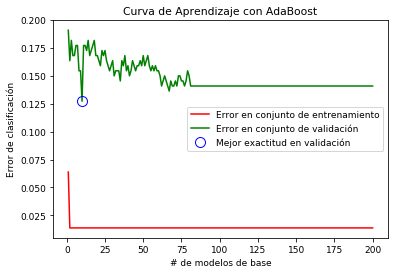

In [39]:
mejor_score = 0
mejor_n_estimators = None

ab_error_train = np.zeros((n_estimators,))
for i, score_train in enumerate(modelo_ab.staged_score(X_train, y_train)):
    ab_error_train[i] = 1 - score_train

ab_error_val = np.zeros((n_estimators,))
for i, score_val in enumerate(modelo_ab.staged_score(X_val, y_val)):
    ab_error_val[i] = 1 - score_val
    if score_val > mejor_score: 
        mejor_score = score_val
        mejor_n_estimators = i + 1

plt.figure()
plt.plot(np.arange(n_estimators) + 1, ab_error_train,
        label='Error en conjunto de entrenamiento',
        color='red')
plt.plot(np.arange(n_estimators) + 1, ab_error_val,
        label='Error en conjunto de validación',
        color='green')
plt.plot(mejor_n_estimators, ab_error_val[mejor_n_estimators - 1], 'o', markersize=10,
         label="Mejor exactitud en validación", fillstyle="none", c='b', mew=1)
plt.xlabel("# de modelos de base")
plt.ylabel("Error de clasificación")
plt.title("Curva de Aprendizaje con AdaBoost")
plt.legend(loc=5, numpoints = 1)
plt.show()

**Pregunta 9:** ¿Cuál de las siguientes afirmaciones representa mejor la curva visualizada?

* El modelo tiene severo overfitting de inicio a fin.
* El modelo obtiene rápidamente su mejor exactitud de validación, pero luego continúa un comportamiento en el que no se observa overfitting. Tal vez este punto no deba ser tomado demasiado en serio.
* El error de entrenamiento es cercano al de validación.


### Curva ROC

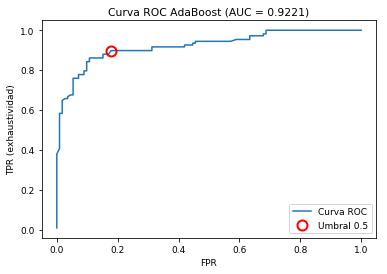

In [40]:
y_pred_val = modelo_ab.predict_proba(X_val)[:,1]
fpr, tpr, umbrales = metrics.roc_curve(y_val, y_pred_val)
auc_roc = metrics.roc_auc_score(y_val, y_pred_val)

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC AdaBoost (AUC = %.4f)" % auc_roc))
# ubicamos el punto más cercano a 0.5
umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(fpr[umbral_05], tpr[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)

**Pregunta 10:** Prueba libremente a mejorar alguno de estos modelos o, si deseas, usa algún otro modelo de ensamble como [sklearn.ensemble.GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). Reporta el área bajo la curva ROC de tu mejor modelo en el conjunto de validación.